In [1]:
import pandas as pd
import numpy as np
import os
import gc
import warnings
from sklearn.metrics import f1_score, recall_score
warnings.filterwarnings("ignore")

In [2]:
def dataset(partition, feature_set):
    train = pd.read_csv(os.path.join('./data_csv/',partition,feature_set+'_train.csv'))
    valid = pd.read_csv(os.path.join('./data_csv/',partition,feature_set+'_devel.csv'))
    return train, valid

In [3]:
def f1(y_true, y_pred):
    return round(f1_score(y_true, y_pred, average='micro') * 100, 3)

def uar(y_true, y_pred):
    return round(recall_score(y_true, y_pred, average='macro') * 100, 3)

def combine(y_true, y_pred):
    return round((0.66 * f1(y_true, y_pred) + 0.34 * uar(y_true, y_pred)), 3)

In [224]:

partition_info = pd.read_csv('/media/sven/New Volume/features/meta/processed_tasks/metadata/partition.csv')

partition = 'arousal'
feature_set = 'xception'
train, valid = dataset(partition, feature_set)
last_columns = '2047'

X_train, y_train = train.loc[:,'0':'{}'.format(last_columns)], train['class_id']
X_valid, y_valid = valid.loc[:,'0':'{}'.format(last_columns)], valid['class_id']

In [225]:
col_name = X_train.columns.tolist()

In [226]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-250:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in col_name]
    return cor_support, cor_feature

In [227]:
cor_support, cor_feature = cor_selector(X_train, y_train)

In [228]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=250)
chi_selector.fit(X_norm, y_train)

SelectKBest(k=250, score_func=<function chi2 at 0x7f7850404200>)

In [229]:
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

250 selected features


In [231]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE

# rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=250, step=10, verbose=5)
# rfe_selector.fit(X_norm,y_train)
# rfe_support = rfe_selector.get_support()
# rfe_feature = X_train.loc[:,rfe_support].columns.tolist()

In [232]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median')
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()



In [233]:
len(embeded_lr_feature)

679

In [234]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=10), threshold='1.25*median')
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()


In [235]:
print(str(len(embeded_rf_feature)), 'selected features')

751 selected features


In [236]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=100, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X_train, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

850 selected features


In [237]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':col_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(3)

ValueError: arrays must all be same length

In [238]:
col_new = feature_selection_df.loc[:250,'Feature'].to_list()


[   0    5    7    8   27   28   44   45   52   54   57   63   66   79
   86   88  108  134  141  145  151  156  160  162  174  178  185  202
  203  208  214  217  220  221  225  226  227  239  240  246  251  261
  264  266  270  273  278  286  288  292  293  297  302  306  308  310
  313  315  317  322  331  334  335  348  349  354  356  359  365  376
  384  387  393  399  402  404  406  407  418  419  422  425  434  435
  443  449  451  456  462  467  469  482  483  492  502  504  512  515
  516  517  518  520  525  526  528  539  546  552  563  570  576  582
  583  585  595  624  636  641  651  667  680  684  686  687  690  694
  695  698  702  705  707  708  712  715  723  732  734  739  750  752
  753  759  760  761  762  763  766  784  790  793  795  796  805  807
  814  819  821  823  826  844  847  865  869  877  889  890  892  893
  895  911  915  920  921  922  925  930  944  947  949  952  955  960
  964  967  972  983  984  987  990  993  998  999 1004 1007 1011 1038
 1051 

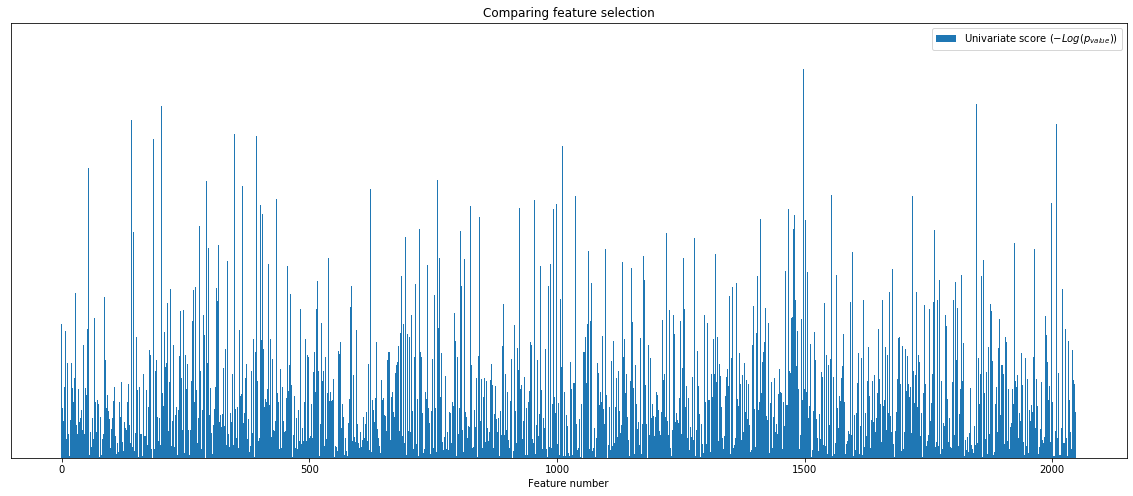

(4313, 409)


In [521]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif



partition_info = pd.read_csv('/media/sven/New Volume/features/meta/processed_tasks/metadata/partition.csv')

partition = 'valence'
feature_set = 'xception'
train, valid = dataset(partition, feature_set)
last_columns = '2047'

X_train, y_train = train.loc[:,'segment_id':'{}'.format(last_columns)], train['class_id']
X_valid, y_valid = valid.loc[:,'segment_id':'{}'.format(last_columns)], valid['class_id']



plt.figure(1, figsize=(20, 8))
plt.clf()

X_indices = np.arange(X_train.shape[-1])

selector = SelectKBest(f_classif, k=int(2048*20/100))
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

print(X_indices[selector.get_support()] )
plt.bar(X_indices - .25, scores, width=1,
        label=r'Univariate score ($-Log(p_{value})$)')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

new = list(X_train[X_train.columns[selector.get_support()]].astype(str))

X_train = X_train.loc[:,new]
X_valid = X_valid.loc[:,new]
print(X_train.shape)




In [526]:
model = RandomForestClassifier(max_depth =7.154066911419742, bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
acc = combine(y_valid, pred)
print(acc)

39.819


In [527]:
print(X_train.shape)
print(X_train.shape)

def objective(trial):

    classifier_name = trial.suggest_categorical('classifier', ['RandomForestClassifier'])

    if classifier_name == 'RandomForestClassifier':
        max_depth = trial.suggest_loguniform('max_depth', 1, 100)
        classifier_obj = RandomForestClassifier(max_depth=max_depth, random_state=1)

    classifier_obj.fit(X_train, y_train)
    pred = classifier_obj.predict(X_valid)

    accuracy = combine(y_valid, pred)
    
    print(classifier_obj.get_params)
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Parameter: {}'.format(trial.params))

(4313, 409)
(4313, 409)
<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15.794465353535303,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:09,586] Finished trial#0 with value: 37.383 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 15.794465353535303}. Best is trial#0 with value: 37.383.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13.42792158192763,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:13,778] Finished trial#1 with value: 37.477 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 13.42792158192763}. Best is trial#1 with value: 37.477.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.5838296159506,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:15,174] Finished trial#2 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.5838296159506}. Best is trial#2 with value: 38.405.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=34.3239423028848,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:19,966] Finished trial#3 with value: 38.095 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 34.3239423028848}. Best is trial#2 with value: 38.405.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.907751278716695,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:20,962] Finished trial#4 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.907751278716695}. Best is trial#2 with value: 38.405.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.181605632212439,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:23,447] Finished trial#5 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.181605632212439}. Best is trial#2 with value: 38.405.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=51.59925778876316,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:28,319] Finished trial#6 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 51.59925778876316}. Best is trial#2 with value: 38.405.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20.80222912689171,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:33,128] Finished trial#7 with value: 38.455 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 20.80222912689171}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.059417224737107,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:34,162] Finished trial#8 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.059417224737107}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.686956191756864,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:35,568] Finished trial#9 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.686956191756864}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=82.39356070467949,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:40,404] Finished trial#10 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 82.39356070467949}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.0685476715386435,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:41,010] Finished trial#11 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.0685476715386435}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20.134607156910796,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:45,865] Finished trial#12 with value: 38.455 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 20.134607156910796}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25.7850131583637,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:50,817] Finished trial#13 with value: 37.61 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 25.7850131583637}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.46938266517032,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:53,929] Finished trial#14 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.46938266517032}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=23.76188026903045,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:11:58,732] Finished trial#15 with value: 36.974 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 23.76188026903045}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=63.95390807180175,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:03,587] Finished trial#16 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 63.95390807180175}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=43.26891808290786,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:08,410] Finished trial#17 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 43.26891808290786}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14.830529905183022,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:12,780] Finished trial#18 with value: 37.923 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 14.830529905183022}. Best is trial#7 with value: 38.455.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.40086325414854,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:15,548] Finished trial#19 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.40086325414854}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9665546266396925,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:18,313] Finished trial#20 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9665546266396925}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.776288012099676,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:20,753] Finished trial#21 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.776288012099676}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.874242157560843,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:24,363] Finished trial#22 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.874242157560843}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.272657325328176,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:26,473] Finished trial#23 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.272657325328176}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.776826992018188,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:29,576] Finished trial#24 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.776826992018188}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.6981405640767082,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:30,194] Finished trial#25 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.6981405640767082}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.036466320435957,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:32,338] Finished trial#26 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.036466320435957}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.1514389662948,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:36,212] Finished trial#27 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.1514389662948}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20.09953963474509,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:41,092] Finished trial#28 with value: 38.455 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 20.09953963474509}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17.302460468096847,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:45,748] Finished trial#29 with value: 36.833 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 17.302460468096847}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=29.803442962044937,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:50,531] Finished trial#30 with value: 37.213 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 29.803442962044937}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14.569648059903175,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:54,864] Finished trial#31 with value: 37.923 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 14.569648059903175}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19.56606562626657,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:12:59,568] Finished trial#32 with value: 37.243 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 19.56606562626657}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12.102011103092355,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:03,596] Finished trial#33 with value: 35.921 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 12.102011103092355}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9659818954432176,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:06,357] Finished trial#34 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9659818954432176}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.775723419697275,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:09,108] Finished trial#35 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.775723419697275}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.485624950954604,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:11,861] Finished trial#36 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.485624950954604}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.854616206730613,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:13,238] Finished trial#37 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.854616206730613}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.661204191290331,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:14,984] Finished trial#38 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.661204191290331}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.9515163449092268,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:15,983] Finished trial#39 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.9515163449092268}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.108716893700778,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:18,424] Finished trial#40 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.108716893700778}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.801301413079141,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:21,509] Finished trial#41 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.801301413079141}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.180838579760407,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:24,297] Finished trial#42 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.180838579760407}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.310722841205932,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:27,084] Finished trial#43 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.310722841205932}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.344432332711249,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:28,882] Finished trial#44 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.344432332711249}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.912853309307234,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:32,288] Finished trial#45 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.912853309307234}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.59557524259193,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:34,382] Finished trial#46 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.59557524259193}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.0836727050580355,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:35,774] Finished trial#47 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.0836727050580355}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.56343281687478,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:38,268] Finished trial#48 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.56343281687478}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.78909005517796,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:40,715] Finished trial#49 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.78909005517796}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12.956934507096788,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:44,763] Finished trial#50 with value: 35.921 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 12.956934507096788}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.720356660013076,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:47,532] Finished trial#51 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.720356660013076}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.18879921473426,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:50,867] Finished trial#52 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.18879921473426}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.107846288848997,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:52,606] Finished trial#53 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.107846288848997}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.040432843678953,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:55,669] Finished trial#54 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.040432843678953}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.0960093743228603,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:13:56,672] Finished trial#55 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.0960093743228603}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.411511373906428,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:00,530] Finished trial#56 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.411511373906428}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.632807615989829,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:02,642] Finished trial#57 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.632807615989829}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.114824249411182,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:05,424] Finished trial#58 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.114824249411182}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.429352818981328,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:06,797] Finished trial#59 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.429352818981328}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.9859201809656,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:10,140] Finished trial#60 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.9859201809656}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.704835994725873,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:12,898] Finished trial#61 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.704835994725873}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.029608218909951,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:15,964] Finished trial#62 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.029608218909951}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.01053649575531,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:18,066] Finished trial#63 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.01053649575531}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.805187808196881,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:20,498] Finished trial#64 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.805187808196881}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15.991008943380157,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:24,955] Finished trial#65 with value: 37.383 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 15.991008943380157}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13.564401750840652,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:29,146] Finished trial#66 with value: 37.477 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 13.564401750840652}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.030561334711703,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:31,594] Finished trial#67 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.030561334711703}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.979293880948225,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:34,938] Finished trial#68 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.979293880948225}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.700116493448076,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:36,688] Finished trial#69 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.700116493448076}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.263560682225386,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:39,764] Finished trial#70 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.263560682225386}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.4043698497355495,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:42,532] Finished trial#71 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.4043698497355495}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.216089320238762,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:45,288] Finished trial#72 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.216089320238762}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3214554793950155,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:48,047] Finished trial#73 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3214554793950155}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.628307105699033,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:50,142] Finished trial#74 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.628307105699033}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.205442111311253,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:53,981] Finished trial#75 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.205442111311253}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.315611729528777,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:57,312] Finished trial#76 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.315611729528777}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.343340620375557,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:14:59,750] Finished trial#77 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.343340620375557}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.355845931079706,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:02,823] Finished trial#78 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.355845931079706}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.943472191814223,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:06,653] Finished trial#79 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.943472191814223}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.31034570547271,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:08,745] Finished trial#80 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.31034570547271}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.182400073581434,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:11,504] Finished trial#81 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.182400073581434}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.252784212648871,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:14,256] Finished trial#82 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.252784212648871}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.155811995849307,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:16,695] Finished trial#83 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.155811995849307}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.485365422699041,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:18,433] Finished trial#84 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.485365422699041}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.606532579869787,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:22,037] Finished trial#85 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.606532579869787}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.191324195835712,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:25,373] Finished trial#86 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.191324195835712}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13.11175492824315,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:29,560] Finished trial#87 with value: 37.477 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 13.11175492824315}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.715095871199416,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:32,323] Finished trial#88 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.715095871199416}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.923990169227633,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:35,081] Finished trial#89 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.923990169227633}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.01587090431635,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:38,434] Finished trial#90 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.01587090431635}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.533229116200048,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:40,878] Finished trial#91 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.533229116200048}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.866148965682362,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:43,326] Finished trial#92 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.866148965682362}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.008887012236212,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:45,417] Finished trial#93 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.008887012236212}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.708536824870866,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:48,187] Finished trial#94 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.708536824870866}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.166805034199324,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:51,853] Finished trial#95 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.166805034199324}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.871040539421336,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:54,009] Finished trial#96 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.871040539421336}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.50668232466958,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:57,118] Finished trial#97 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.50668232466958}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.098348748916364,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:15:58,861] Finished trial#98 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.098348748916364}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.4842704003887235,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:00,960] Finished trial#99 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.4842704003887235}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.610343373334022,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:04,318] Finished trial#100 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.610343373334022}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.89910766604402,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:06,747] Finished trial#101 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.89910766604402}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.292769591603786,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:09,501] Finished trial#102 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.292769591603786}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.18391427807892,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:11,947] Finished trial#103 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.18391427807892}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.613603533765701,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:15,009] Finished trial#104 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.613603533765701}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.8368326973470515,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:17,788] Finished trial#105 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.8368326973470515}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.7648154529556725,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:20,553] Finished trial#106 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.7648154529556725}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.023697681584078,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:24,389] Finished trial#107 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.023697681584078}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.892254506655773,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:26,143] Finished trial#108 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.892254506655773}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.42130620952308,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:29,755] Finished trial#109 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.42130620952308}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.016218198853657,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:33,101] Finished trial#110 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.016218198853657}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.668855796989382,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:35,858] Finished trial#111 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.668855796989382}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.703949418257716,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:38,611] Finished trial#112 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.703949418257716}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.302755642091211,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:41,046] Finished trial#113 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.302755642091211}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.071278908934614,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:43,803] Finished trial#114 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.071278908934614}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.7352493456660305,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:45,897] Finished trial#115 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.7352493456660305}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.132094112378832,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:48,955] Finished trial#116 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.132094112378832}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12.37108137188232,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:52,980] Finished trial#117 with value: 35.921 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 12.37108137188232}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.304927783766145,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:56,325] Finished trial#118 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.304927783766145}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.913571869838844,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:16:59,099] Finished trial#119 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.913571869838844}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.790335258364722,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:01,540] Finished trial#120 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.790335258364722}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9436436849923835,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:04,299] Finished trial#121 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9436436849923835}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.584662597299443,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:07,364] Finished trial#122 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.584662597299443}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.286840506892301,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:10,130] Finished trial#123 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.286840506892301}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.116444372548677,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:12,892] Finished trial#124 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.116444372548677}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.436808279149294,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:15,321] Finished trial#125 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.436808279149294}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.211041031701796,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:17,429] Finished trial#126 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.211041031701796}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.897169033031323,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:20,756] Finished trial#127 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.897169033031323}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.909408294291731,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:22,850] Finished trial#128 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.909408294291731}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.252995300674046,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:26,692] Finished trial#129 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.252995300674046}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.586004635981975,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:29,759] Finished trial#130 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.586004635981975}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.741800891021971,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:32,514] Finished trial#131 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.741800891021971}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.663757431197847,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:35,267] Finished trial#132 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.663757431197847}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.4695867232637925,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:37,711] Finished trial#133 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.4695867232637925}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9439603662001215,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:40,475] Finished trial#134 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9439603662001215}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.989408123656538,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:42,911] Finished trial#135 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.989408123656538}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.524357305448639,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:46,237] Finished trial#136 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.524357305448639}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.272940368699226,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:49,315] Finished trial#137 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.272940368699226}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.036687599679321,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:52,080] Finished trial#138 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.036687599679321}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.685077151417269,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:54,176] Finished trial#139 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.685077151417269}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.366661029071409,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:17:57,783] Finished trial#140 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.366661029071409}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.403898549915067,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:00,233] Finished trial#141 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.403898549915067}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.758351004426082,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:03,000] Finished trial#142 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.758351004426082}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.1651363032362365,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:05,781] Finished trial#143 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.1651363032362365}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.268970657432673,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:07,875] Finished trial#144 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.268970657432673}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.143273785427235,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:10,635] Finished trial#145 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.143273785427235}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.982324446548386,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:13,700] Finished trial#146 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.982324446548386}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.114466019748068,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:16,135] Finished trial#147 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.114466019748068}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.654324532480425,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:19,217] Finished trial#148 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.654324532480425}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.497538934588784,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:21,979] Finished trial#149 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.497538934588784}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.691050521898777,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:25,312] Finished trial#150 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.691050521898777}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.6106390200682945,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:27,754] Finished trial#151 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.6106390200682945}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.550867979172363,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:30,514] Finished trial#152 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.550867979172363}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.578255730351306,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:33,273] Finished trial#153 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.578255730351306}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.882643966809426,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:35,713] Finished trial#154 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.882643966809426}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.967768581626439,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:38,475] Finished trial#155 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.967768581626439}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.166332488167582,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:41,542] Finished trial#156 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.166332488167582}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.838695463581974,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:44,600] Finished trial#157 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.838695463581974}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.109281548331412,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:47,033] Finished trial#158 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.109281548331412}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.90892685470678,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:49,466] Finished trial#159 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.90892685470678}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.104742217458159,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:52,222] Finished trial#160 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.104742217458159}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.244793773180542,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:54,974] Finished trial#161 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.244793773180542}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.820633778764461,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:57,073] Finished trial#162 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.820633778764461}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.454104699742412,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:18:59,513] Finished trial#163 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.454104699742412}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.413937349357875,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:02,857] Finished trial#164 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.413937349357875}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.550848450526463,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:05,917] Finished trial#165 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.550848450526463}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.344558756603028,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:08,009] Finished trial#166 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.344558756603028}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.741237797537994,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:10,750] Finished trial#167 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.741237797537994}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.722837293371827,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:14,345] Finished trial#168 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.722837293371827}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.078653492356748,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:17,095] Finished trial#169 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.078653492356748}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.622538861553863,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:19,531] Finished trial#170 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.622538861553863}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.505146364381109,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:22,295] Finished trial#171 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.505146364381109}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.430019830532233,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:25,368] Finished trial#172 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.430019830532233}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.342862199604819,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:28,129] Finished trial#173 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.342862199604819}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.622814744412029,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:30,884] Finished trial#174 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.622814744412029}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.955661235705657,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:32,982] Finished trial#175 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.955661235705657}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.000091505719445,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:35,733] Finished trial#176 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.000091505719445}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.255627424913957,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:39,077] Finished trial#177 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.255627424913957}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.494036663018832,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:41,507] Finished trial#178 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.494036663018832}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.153377333855623,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:44,575] Finished trial#179 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.153377333855623}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.710627349279903,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:46,323] Finished trial#180 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.710627349279903}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.114082954572977,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:49,080] Finished trial#181 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.114082954572977}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.238670192183377,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:51,841] Finished trial#182 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.238670192183377}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.492065467650878,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:54,906] Finished trial#183 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.492065467650878}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.080768268782872,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:55,509] Finished trial#184 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.080768268782872}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.066244183335353,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:19:57,952] Finished trial#185 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.066244183335353}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=86.72093114017015,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:02,760] Finished trial#186 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 86.72093114017015}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.843003684528429,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:05,526] Finished trial#187 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.843003684528429}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.410803275697504,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:08,871] Finished trial#188 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.410803275697504}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.37732009894062,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:11,627] Finished trial#189 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.37732009894062}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.995894234968055,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:14,377] Finished trial#190 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.995894234968055}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.751865567706391,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:16,808] Finished trial#191 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.751865567706391}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.313691829290338,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:19,566] Finished trial#192 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.313691829290338}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.549622685638033,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:21,663] Finished trial#193 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.549622685638033}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.389170039888863,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:24,102] Finished trial#194 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.389170039888863}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.654866957565025,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:27,166] Finished trial#195 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.654866957565025}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.881188323021957,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:29,934] Finished trial#196 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.881188323021957}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.733762046651369,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:32,695] Finished trial#197 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.733762046651369}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.674615070230046,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:35,130] Finished trial#198 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.674615070230046}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.0312265185664895,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:37,892] Finished trial#199 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.0312265185664895}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.063528308522637,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:40,643] Finished trial#200 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.063528308522637}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.310963699245325,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:43,398] Finished trial#201 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.310963699245325}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.073261830125228,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:46,146] Finished trial#202 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.073261830125228}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.201098412778123,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:49,210] Finished trial#203 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.201098412778123}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.096228017228675,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:52,808] Finished trial#204 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.096228017228675}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.128680529932938,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:55,244] Finished trial#205 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.128680529932938}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.9145432836045,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:20:58,326] Finished trial#206 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.9145432836045}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.525928208783327,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:00,765] Finished trial#207 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.525928208783327}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.084853486940064,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:03,826] Finished trial#208 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.084853486940064}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.499609352569535,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:06,593] Finished trial#209 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.499609352569535}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.458830160015904,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:09,347] Finished trial#210 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.458830160015904}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.915639936274736,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:12,129] Finished trial#211 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.915639936274736}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.344631667454898,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:15,246] Finished trial#212 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.344631667454898}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.47371819298756,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:18,011] Finished trial#213 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.47371819298756}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.307231121246499,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:21,351] Finished trial#214 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.307231121246499}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.167653904272536,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:24,418] Finished trial#215 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.167653904272536}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.757151874608253,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:26,903] Finished trial#216 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.757151874608253}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.766366517398819,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:29,991] Finished trial#217 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.766366517398819}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.767257973024734,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:32,090] Finished trial#218 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.767257973024734}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.950944140545505,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:34,860] Finished trial#219 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.950944140545505}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.6995526571399555,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:37,626] Finished trial#220 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.6995526571399555}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.755304179450995,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:40,423] Finished trial#221 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.755304179450995}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.843926067072709,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:42,906] Finished trial#222 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.843926067072709}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.620713348268288,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:45,372] Finished trial#223 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.620713348268288}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.160957179154687,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:47,814] Finished trial#224 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.160957179154687}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.352548684808816,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:50,610] Finished trial#225 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.352548684808816}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.953561252740043,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:53,747] Finished trial#226 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.953561252740043}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.358430219847222,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:56,570] Finished trial#227 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.358430219847222}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.082868203897475,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:21:59,343] Finished trial#228 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.082868203897475}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.5290413474846,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:02,414] Finished trial#229 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.5290413474846}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.263880496291813,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:04,935] Finished trial#230 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.263880496291813}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.169676139406001,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:07,791] Finished trial#231 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.169676139406001}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.085483450913802,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:10,608] Finished trial#232 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.085483450913802}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.767739712800037,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:13,467] Finished trial#233 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.767739712800037}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.650049514506698,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:15,957] Finished trial#234 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.650049514506698}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.135821000147077,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:19,061] Finished trial#235 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.135821000147077}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.653697109863629,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:21,844] Finished trial#236 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.653697109863629}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.905322634091116,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:25,182] Finished trial#237 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.905322634091116}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.565894252478069,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:27,941] Finished trial#238 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.565894252478069}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.965147757865624,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:31,006] Finished trial#239 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.965147757865624}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.783769358845723,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:33,104] Finished trial#240 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.783769358845723}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.265591336921089,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:36,188] Finished trial#241 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.265591336921089}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.959500030440459,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:38,681] Finished trial#242 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.959500030440459}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.665828656154436,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:41,451] Finished trial#243 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.665828656154436}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.27524631805861,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:44,565] Finished trial#244 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.27524631805861}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.07449404171654,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:47,358] Finished trial#245 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.07449404171654}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.7181811344184545,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:49,880] Finished trial#246 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.7181811344184545}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.154435236758184,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:52,492] Finished trial#247 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.154435236758184}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.2822307331005325,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:55,315] Finished trial#248 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.2822307331005325}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.071894647114727,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:22:58,711] Finished trial#249 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.071894647114727}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.716786040568357,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:01,517] Finished trial#250 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.716786040568357}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.493500605632271,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:04,133] Finished trial#251 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.493500605632271}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.187068825350612,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:07,318] Finished trial#252 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.187068825350612}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.830864930759224,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:10,134] Finished trial#253 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.830864930759224}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.182059403769674,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:13,348] Finished trial#254 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.182059403769674}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.35895054192414,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:16,813] Finished trial#255 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.35895054192414}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.717135536985013,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:19,906] Finished trial#256 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.717135536985013}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.2189716946914055,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:22,613] Finished trial#257 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.2189716946914055}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.6035401649327,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:26,398] Finished trial#258 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.6035401649327}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.437411879011384,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:29,285] Finished trial#259 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.437411879011384}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.758077901763544,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:32,431] Finished trial#260 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.758077901763544}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.933948810278846,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:35,230] Finished trial#261 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.933948810278846}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.789325457278063,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:38,038] Finished trial#262 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.789325457278063}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.428930123043795,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:40,493] Finished trial#263 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.428930123043795}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.851099963179067,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:42,937] Finished trial#264 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.851099963179067}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.610458625272807,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:45,031] Finished trial#265 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.610458625272807}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.151987294880008,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:47,463] Finished trial#266 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.151987294880008}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.100385251850353,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:50,223] Finished trial#267 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.100385251850353}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.7552471658715945,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:52,658] Finished trial#268 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.7552471658715945}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.4334766134841335,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:54,754] Finished trial#269 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.4334766134841335}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.678608307985108,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:23:57,815] Finished trial#270 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.678608307985108}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.132576239876536,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:00,575] Finished trial#271 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.132576239876536}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.88050239238231,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:02,699] Finished trial#272 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.88050239238231}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.580929325024908,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:06,090] Finished trial#273 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.580929325024908}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=41.91253133983901,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:10,933] Finished trial#274 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 41.91253133983901}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9015652529565745,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:13,743] Finished trial#275 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9015652529565745}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.20634401854178,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:16,801] Finished trial#276 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.20634401854178}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.536515579207902,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:19,555] Finished trial#277 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.536515579207902}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.873676991764391,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:22,673] Finished trial#278 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.873676991764391}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.380047462340146,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:25,449] Finished trial#279 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.380047462340146}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.31166723411211,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:29,075] Finished trial#280 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.31166723411211}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.645914546669446,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:31,919] Finished trial#281 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.645914546669446}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.9876512756095615,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:34,907] Finished trial#282 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.9876512756095615}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.30577076058269,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:38,002] Finished trial#283 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.30577076058269}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.430308145837175,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:40,459] Finished trial#284 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.430308145837175}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.757140798929466,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:43,549] Finished trial#285 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.757140798929466}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.653440955117527,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:46,352] Finished trial#286 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.653440955117527}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.67273682308633,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:48,835] Finished trial#287 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.67273682308633}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.252061232129819,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:51,648] Finished trial#288 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.252061232129819}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.030226012402885,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:54,169] Finished trial#289 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.030226012402885}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.371445539860774,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:56,613] Finished trial#290 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.371445539860774}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.22704156357697,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:24:59,960] Finished trial#291 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.22704156357697}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.433693329713517,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:03,040] Finished trial#292 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.433693329713517}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.811991420580143,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:05,474] Finished trial#293 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.811991420580143}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.123040462328475,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:07,563] Finished trial#294 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.123040462328475}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.11457327616353,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:10,320] Finished trial#295 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.11457327616353}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.201716192301477,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:13,391] Finished trial#296 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.201716192301477}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.884078005107459,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:15,839] Finished trial#297 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.884078005107459}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.024528845521267,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:19,452] Finished trial#298 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.024528845521267}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=66.68581814141885,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:24,244] Finished trial#299 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 66.68581814141885}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.371096509870732,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:26,988] Finished trial#300 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.371096509870732}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.8442932265274115,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:29,747] Finished trial#301 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.8442932265274115}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.171989909063896,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:33,081] Finished trial#302 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.171989909063896}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.271077391114477,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:35,516] Finished trial#303 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.271077391114477}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.000928643352012,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:38,584] Finished trial#304 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.000928643352012}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.681804115219294,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:40,676] Finished trial#305 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.681804115219294}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.73282233097364,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:43,106] Finished trial#306 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.73282233097364}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.518791994815841,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:45,854] Finished trial#307 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.518791994815841}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.690165626862246,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:48,917] Finished trial#308 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.690165626862246}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.221213763512695,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:51,675] Finished trial#309 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.221213763512695}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.564689462097827,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:54,436] Finished trial#310 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.564689462097827}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.5088543994720105,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:25:56,876] Finished trial#311 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.5088543994720105}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.061002433109913,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:00,726] Finished trial#312 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.061002433109913}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.240156512681997,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:03,164] Finished trial#313 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.240156512681997}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.301017116302583,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:06,240] Finished trial#314 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.301017116302583}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.1703719182332915,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:08,996] Finished trial#315 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.1703719182332915}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.971717357313195,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:11,437] Finished trial#316 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.971717357313195}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.458282542165522,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:14,789] Finished trial#317 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.458282542165522}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.776747494207486,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:16,883] Finished trial#318 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.776747494207486}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.5428894825586745,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:19,310] Finished trial#319 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.5428894825586745}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3403003740193915,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:22,062] Finished trial#320 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3403003740193915}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.405969165591824,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:25,123] Finished trial#321 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.405969165591824}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.967258467211477,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:27,894] Finished trial#322 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.967258467211477}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.68518227288541,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:30,973] Finished trial#323 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.68518227288541}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.04255035831078,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:34,051] Finished trial#324 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.04255035831078}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.19218803092838,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:37,405] Finished trial#325 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.19218803092838}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.65772590694287,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:40,166] Finished trial#326 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.65772590694287}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.491414826624678,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:42,933] Finished trial#327 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.491414826624678}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.779757243042456,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:45,362] Finished trial#328 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.779757243042456}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.939756064483378,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:48,696] Finished trial#329 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.939756064483378}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.747006851536211,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:51,760] Finished trial#330 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.747006851536211}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.768052731875329,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:54,514] Finished trial#331 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.768052731875329}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.800069609553439,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:57,274] Finished trial#332 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.800069609553439}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.0513168197514995,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:26:59,717] Finished trial#333 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.0513168197514995}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.820590947365305,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:02,167] Finished trial#334 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.820590947365305}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.50317073955691,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:05,236] Finished trial#335 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.50317073955691}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.037035426226996,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:08,285] Finished trial#336 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.037035426226996}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.570574413049233,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:11,632] Finished trial#337 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.570574413049233}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.531420047058646,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:15,237] Finished trial#338 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.531420047058646}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.293015686672506,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:17,340] Finished trial#339 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.293015686672506}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.0137934973688765,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:20,110] Finished trial#340 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.0137934973688765}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.966924766617,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:23,181] Finished trial#341 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.966924766617}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.419579278856204,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:25,611] Finished trial#342 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.419579278856204}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.903228325898427,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:28,360] Finished trial#343 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.903228325898427}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.716928971194872,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:30,464] Finished trial#344 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.716928971194872}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.120590527082089,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:33,223] Finished trial#345 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.120590527082089}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.398158222305642,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:35,976] Finished trial#346 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.398158222305642}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.572912925851803,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:38,409] Finished trial#347 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.572912925851803}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.277769634785669,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:41,160] Finished trial#348 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.277769634785669}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.015062775870609,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:43,598] Finished trial#349 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.015062775870609}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.40729578075516,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:46,663] Finished trial#350 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.40729578075516}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.436341345204141,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:49,105] Finished trial#351 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.436341345204141}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.430275104822667,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:51,863] Finished trial#352 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.430275104822667}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.799584531763146,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:54,299] Finished trial#353 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.799584531763146}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.15281956438651,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:27:57,364] Finished trial#354 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.15281956438651}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.109928037086995,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:00,709] Finished trial#355 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.109928037086995}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.6321834146217595,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:03,468] Finished trial#356 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.6321834146217595}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.546507985110464,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:06,810] Finished trial#357 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.546507985110464}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3544922370694685,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:09,572] Finished trial#358 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3544922370694685}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.946383445256433,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:11,669] Finished trial#359 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.946383445256433}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.4260503743813295,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:14,426] Finished trial#360 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.4260503743813295}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.4638944021915234,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:16,860] Finished trial#361 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.4638944021915234}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.500934158087528,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:19,923] Finished trial#362 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.500934158087528}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.330133807179234,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:22,996] Finished trial#363 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.330133807179234}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.01330406165172,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:26,336] Finished trial#364 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.01330406165172}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.829589983487365,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:28,776] Finished trial#365 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.829589983487365}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.928633793242147,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:31,537] Finished trial#366 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.928633793242147}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.102631716178031,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:35,138] Finished trial#367 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.102631716178031}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.058758359124332,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:37,898] Finished trial#368 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.058758359124332}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.108757834754131,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:40,963] Finished trial#369 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.108757834754131}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.502389563754828,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:43,719] Finished trial#370 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.502389563754828}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.361644467102864,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:45,814] Finished trial#371 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.361644467102864}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.154257779034091,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:48,250] Finished trial#372 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.154257779034091}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.753465784392674,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:52,088] Finished trial#373 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.753465784392674}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.61184972778059,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:54,845] Finished trial#374 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.61184972778059}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.747102870646376,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:57,280] Finished trial#375 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.747102870646376}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.910003034345507,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:28:59,716] Finished trial#376 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.910003034345507}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.029560653447575,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:02,153] Finished trial#377 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.029560653447575}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.335556416165767,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:04,585] Finished trial#378 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.335556416165767}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.768427426111646,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:07,655] Finished trial#379 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.768427426111646}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.268087532182417,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:10,722] Finished trial#380 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.268087532182417}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.745849422146021,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:14,061] Finished trial#381 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.745849422146021}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.117083885525165,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:16,820] Finished trial#382 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.117083885525165}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.582275820416478,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:19,570] Finished trial#383 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.582275820416478}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.710972958037331,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:22,646] Finished trial#384 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.710972958037331}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.843867854098569,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:25,404] Finished trial#385 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.843867854098569}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.5939751322983815,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:27,498] Finished trial#386 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.5939751322983815}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.195607777720927,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:30,841] Finished trial#387 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.195607777720927}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.083014859304276,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:33,601] Finished trial#388 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.083014859304276}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.519092546952556,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:36,032] Finished trial#389 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.519092546952556}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.858894806681012,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:38,472] Finished trial#390 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.858894806681012}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.730263806509971,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:41,232] Finished trial#391 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.730263806509971}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.899510105185176,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:43,989] Finished trial#392 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.899510105185176}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.309427051472018,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:46,427] Finished trial#393 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.309427051472018}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.548566836500248,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:49,498] Finished trial#394 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.548566836500248}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.520830174613277,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:52,837] Finished trial#395 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.520830174613277}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.388943650750845,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:56,436] Finished trial#396 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.388943650750845}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.09884914258959,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:29:58,534] Finished trial#397 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.09884914258959}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.801213470178543,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:00,985] Finished trial#398 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.801213470178543}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.43372172208011,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:03,748] Finished trial#399 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.43372172208011}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.006639107643628,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:06,189] Finished trial#400 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.006639107643628}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.418780634641122,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:09,263] Finished trial#401 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.418780634641122}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.253867332277227,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:12,027] Finished trial#402 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.253867332277227}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.101358053779184,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:14,782] Finished trial#403 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.101358053779184}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.092055591545869,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:15,788] Finished trial#404 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.092055591545869}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.6468494988819105,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:17,882] Finished trial#405 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.6468494988819105}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.466219716473311,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:20,325] Finished trial#406 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.466219716473311}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.426135405667662,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:20,930] Finished trial#407 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.426135405667662}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.671849007801402,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:23,684] Finished trial#408 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.671849007801402}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.841950427998586,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:26,435] Finished trial#409 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.841950427998586}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.042952930774121,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:29,191] Finished trial#410 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.042952930774121}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.059204583972038,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:32,529] Finished trial#411 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.059204583972038}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.508795953114964,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:35,586] Finished trial#412 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.508795953114964}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.059577702536764,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:38,645] Finished trial#413 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.059577702536764}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.056413496168448,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:41,704] Finished trial#414 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.056413496168448}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.56740660669108,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:44,461] Finished trial#415 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.56740660669108}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.38484780989541,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:47,795] Finished trial#416 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.38484780989541}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.37688384779811,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:50,858] Finished trial#417 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.37688384779811}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.226824574302203,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:53,292] Finished trial#418 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.226824574302203}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.277530061814946,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:56,046] Finished trial#419 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.277530061814946}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.61735224697811,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:30:58,483] Finished trial#420 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.61735224697811}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.365436954861094,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:02,323] Finished trial#421 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.365436954861094}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.8281830982930085,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:04,418] Finished trial#422 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.8281830982930085}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.721602800638182,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:06,159] Finished trial#423 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.721602800638182}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.670970986929853,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:08,594] Finished trial#424 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.670970986929853}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.970404778839601,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:11,032] Finished trial#425 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.970404778839601}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.401242470042556,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:13,798] Finished trial#426 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.401242470042556}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.247593603472886,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:16,237] Finished trial#427 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.247593603472886}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.871371542526534,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:19,305] Finished trial#428 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.871371542526534}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.771216011516556,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:22,058] Finished trial#429 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.771216011516556}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.049502342768587,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:24,811] Finished trial#430 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.049502342768587}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.78061936030476,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:26,942] Finished trial#431 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.78061936030476}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.938305320175811,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:29,695] Finished trial#432 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.938305320175811}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.935930066385767,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:33,038] Finished trial#433 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.935930066385767}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.822171294648284,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:36,109] Finished trial#434 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.822171294648284}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.313106040719685,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:39,175] Finished trial#435 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.313106040719685}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=27.918334058365648,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:43,964] Finished trial#436 with value: 37.199 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 27.918334058365648}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.508823435347765,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:46,728] Finished trial#437 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.508823435347765}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.634926251043142,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:49,164] Finished trial#438 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.634926251043142}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.809451483266171,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:52,768] Finished trial#439 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.809451483266171}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.4111252025888295,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:55,522] Finished trial#440 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.4111252025888295}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.388929142468246,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:31:57,956] Finished trial#441 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.388929142468246}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.254390950978273,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:01,034] Finished trial#442 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.254390950978273}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.913932020389261,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:03,788] Finished trial#443 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.913932020389261}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.877785567154795,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:06,235] Finished trial#444 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.877785567154795}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.324159657677095,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:08,342] Finished trial#445 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.324159657677095}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.665745199170193,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:11,700] Finished trial#446 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.665745199170193}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.007548911368961,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:14,136] Finished trial#447 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.007548911368961}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.333623924434986,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:16,892] Finished trial#448 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.333623924434986}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.977590434710963,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:19,975] Finished trial#449 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.977590434710963}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.724778864005311,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:22,415] Finished trial#450 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.724778864005311}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.497032736653098,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:25,475] Finished trial#451 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.497032736653098}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.469385752180354,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:27,910] Finished trial#452 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.469385752180354}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.904939083576013,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:30,012] Finished trial#453 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.904939083576013}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.397468877833322,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:32,760] Finished trial#454 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.397468877833322}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.089736194892431,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:35,509] Finished trial#455 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.089736194892431}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.298677110865274,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:38,269] Finished trial#456 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.298677110865274}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.835809034016771,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:40,705] Finished trial#457 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.835809034016771}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.041411861701752,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:43,767] Finished trial#458 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.041411861701752}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.537971404123322,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:47,106] Finished trial#459 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.537971404123322}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.3309206368137065,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:49,544] Finished trial#460 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.3309206368137065}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.737641115480358,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:52,609] Finished trial#461 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.737641115480358}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.422598866396093,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:56,210] Finished trial#462 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.422598866396093}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.020969720154472,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:32:59,275] Finished trial#463 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.020969720154472}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.967838041093057,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:01,709] Finished trial#464 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.967838041093057}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.036546655299567,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:05,043] Finished trial#465 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.036546655299567}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.5431720024251994,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:06,055] Finished trial#466 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.5431720024251994}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.03950410886228,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:09,144] Finished trial#467 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.03950410886228}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.542583500323592,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:11,239] Finished trial#468 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.542583500323592}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.646430928526671,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:14,000] Finished trial#469 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.646430928526671}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.691395968933479,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:16,798] Finished trial#470 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.691395968933479}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.54201580054071,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:19,263] Finished trial#471 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.54201580054071}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.288636083023697,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:22,616] Finished trial#472 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.288636083023697}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.2717633848907655,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:25,395] Finished trial#473 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.2717633848907655}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.406103855217029,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:28,155] Finished trial#474 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.406103855217029}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.202040870865847,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:31,238] Finished trial#475 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.202040870865847}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.982584171533849,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:33,684] Finished trial#476 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.982584171533849}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.739285024973896,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:36,795] Finished trial#477 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.739285024973896}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.850586624703991,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:39,658] Finished trial#478 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.850586624703991}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.03447085840841,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:42,133] Finished trial#479 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.03447085840841}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.625586068789514,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:44,589] Finished trial#480 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.625586068789514}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.20140873047128,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:47,747] Finished trial#481 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.20140873047128}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.04282355801808,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:51,381] Finished trial#482 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.04282355801808}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.267036374585404,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:54,815] Finished trial#483 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.267036374585404}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.52422672544816,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:33:58,009] Finished trial#484 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.52422672544816}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.861786128912111,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:00,826] Finished trial#485 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.861786128912111}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.504583732337038,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:03,677] Finished trial#486 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.504583732337038}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.738588984338628,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:06,494] Finished trial#487 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.738588984338628}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.35274031620996,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:09,331] Finished trial#488 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.35274031620996}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=98.08627465377872,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:14,229] Finished trial#489 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 98.08627465377872}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.1698957025551335,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:16,716] Finished trial#490 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.1698957025551335}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.444691841353858,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:18,854] Finished trial#491 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.444691841353858}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.72943732596727,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:21,334] Finished trial#492 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.72943732596727}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.960040483788746,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:23,814] Finished trial#493 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.960040483788746}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.139060950891451,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:26,321] Finished trial#494 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.139060950891451}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.2626107184060915,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:29,157] Finished trial#495 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.2626107184060915}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.098952773355834,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:31,974] Finished trial#496 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.098952773355834}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.435783947626929,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:34,449] Finished trial#497 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.435783947626929}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.67074860158047,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:37,532] Finished trial#498 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.67074860158047}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.105842623615756,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:39,639] Finished trial#499 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.105842623615756}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.346926726904126,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:42,713] Finished trial#500 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.346926726904126}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.684569597251265,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:44,813] Finished trial#501 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.684569597251265}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.929665421930552,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:47,580] Finished trial#502 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.929665421930552}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.010568530241207,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:50,933] Finished trial#503 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.010568530241207}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.896945873160924,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:53,373] Finished trial#504 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.896945873160924}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.634534262037069,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:56,125] Finished trial#505 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.634534262037069}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.38621533241168,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:34:59,190] Finished trial#506 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.38621533241168}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.77430203103835,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:01,633] Finished trial#507 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.77430203103835}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.081815793418344,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:04,066] Finished trial#508 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.081815793418344}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.658094690841189,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:06,834] Finished trial#509 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.658094690841189}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.485028773957447,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:09,298] Finished trial#510 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.485028773957447}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.312052527182347,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:12,137] Finished trial#511 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.312052527182347}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.267610064337252,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:14,921] Finished trial#512 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.267610064337252}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.871029264465975,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:18,250] Finished trial#513 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.871029264465975}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.652555218310813,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:21,324] Finished trial#514 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.652555218310813}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.599013887544663,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:24,918] Finished trial#515 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.599013887544663}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.435798033440983,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:27,351] Finished trial#516 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.435798033440983}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.061366911966921,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:30,705] Finished trial#517 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.061366911966921}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.061796526935728,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:33,775] Finished trial#518 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.061796526935728}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.448560362358151,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:36,544] Finished trial#519 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.448560362358151}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.911015591512902,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:38,982] Finished trial#520 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.911015591512902}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.513992483814864,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:41,083] Finished trial#521 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.513992483814864}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.748964569411073,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:43,841] Finished trial#522 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.748964569411073}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.023886416724733,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:46,273] Finished trial#523 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.023886416724733}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.18571423729829,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:49,332] Finished trial#524 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.18571423729829}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.589364153414114,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:51,778] Finished trial#525 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.589364153414114}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.189020312816737,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:54,527] Finished trial#526 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.189020312816737}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.705652734336479,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:56,955] Finished trial#527 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.705652734336479}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.4974095358850406,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:35:59,715] Finished trial#528 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.4974095358850406}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.314246350077074,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:02,785] Finished trial#529 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.314246350077074}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.022450686038972,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:05,231] Finished trial#530 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.022450686038972}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.965806835541162,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:08,285] Finished trial#531 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.965806835541162}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.479777946627308,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:11,650] Finished trial#532 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.479777946627308}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.004006046696878,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:14,727] Finished trial#533 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.004006046696878}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.423583782703092,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:18,067] Finished trial#534 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.423583782703092}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.068643118474707,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:20,831] Finished trial#535 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.068643118474707}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.431255453056179,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:23,269] Finished trial#536 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.431255453056179}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.345849727070402,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:26,030] Finished trial#537 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.345849727070402}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.248049898610567,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:28,819] Finished trial#538 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.248049898610567}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.205692529267657,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:31,258] Finished trial#539 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.205692529267657}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.02461387729286,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:34,322] Finished trial#540 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.02461387729286}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12.289052651454517,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:38,345] Finished trial#541 with value: 35.921 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 12.289052651454517}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.56640566288323,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:41,419] Finished trial#542 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.56640566288323}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.659971756248422,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:43,523] Finished trial#543 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.659971756248422}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.004287686854325,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:46,295] Finished trial#544 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.004287686854325}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.844271251533558,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:48,736] Finished trial#545 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.844271251533558}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.548201155439848,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:51,813] Finished trial#546 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.548201155439848}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.841059535710173,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:53,921] Finished trial#547 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.841059535710173}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=21.58241144371202,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:36:58,710] Finished trial#548 with value: 36.445 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 21.58241144371202}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.266390927462632,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:02,379] Finished trial#549 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.266390927462632}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.08911816426087,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:05,475] Finished trial#550 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.08911816426087}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.311577235023882,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:08,273] Finished trial#551 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.311577235023882}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.540179953349937,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:10,729] Finished trial#552 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.540179953349937}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.09332490421031,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:14,076] Finished trial#553 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.09332490421031}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.826504431309391,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:16,847] Finished trial#554 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.826504431309391}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.804329430991069,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:19,296] Finished trial#555 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.804329430991069}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.885445978303808,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:21,053] Finished trial#556 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.885445978303808}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.228722955551133,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:23,495] Finished trial#557 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.228722955551133}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.696306432513817,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:26,850] Finished trial#558 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.696306432513817}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.280301872090302,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:29,618] Finished trial#559 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.280301872090302}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.913837220165292,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:32,390] Finished trial#560 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.913837220165292}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.566430243644945,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:35,464] Finished trial#561 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.566430243644945}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.619661833357417,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:38,237] Finished trial#562 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.619661833357417}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.633695389767618,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:40,697] Finished trial#563 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.633695389767618}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.471704833552126,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:42,802] Finished trial#564 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.471704833552126}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.645072661911872,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:45,579] Finished trial#565 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.645072661911872}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.459421570880435,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:48,658] Finished trial#566 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.459421570880435}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.196990746155145,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:51,427] Finished trial#567 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.196990746155145}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.993545154861113,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:54,503] Finished trial#568 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.993545154861113}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.104980045414279,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:56,955] Finished trial#569 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.104980045414279}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.801998547448661,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:37:59,718] Finished trial#570 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.801998547448661}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.81072012694972,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:03,084] Finished trial#571 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.81072012694972}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.9065835969832206,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:05,537] Finished trial#572 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.9065835969832206}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.329570373279881,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:07,984] Finished trial#573 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.329570373279881}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.11342526906025,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:10,776] Finished trial#574 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.11342526906025}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.617910335955821,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:12,876] Finished trial#575 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.617910335955821}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.592258492289966,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:15,639] Finished trial#576 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.592258492289966}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.232024030609542,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:18,771] Finished trial#577 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.232024030609542}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.204295545034526,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:22,703] Finished trial#578 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.204295545034526}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.507755356340917,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:25,785] Finished trial#579 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.507755356340917}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.565148451156661,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:28,549] Finished trial#580 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.565148451156661}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.528168376983772,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:31,013] Finished trial#581 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.528168376983772}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.264016962080762,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:34,369] Finished trial#582 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.264016962080762}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.906694430340508,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:36,824] Finished trial#583 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.906694430340508}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.007464610751693,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:39,268] Finished trial#584 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.007464610751693}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.644314209568272,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:42,041] Finished trial#585 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.644314209568272}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.832057887811382,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:44,806] Finished trial#586 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.832057887811382}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.634071021019775,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:47,250] Finished trial#587 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.634071021019775}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.8620899553094805,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:49,704] Finished trial#588 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.8620899553094805}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.225686819418508,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:52,477] Finished trial#589 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.225686819418508}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.478996188929312,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:55,560] Finished trial#590 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.478996188929312}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.184889869279815,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:38:57,666] Finished trial#591 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.184889869279815}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.131601219695595,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:00,123] Finished trial#592 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.131601219695595}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.876460041602327,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:03,293] Finished trial#593 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.876460041602327}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.309123296855422,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:05,084] Finished trial#594 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.309123296855422}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.067088434200616,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:07,892] Finished trial#595 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.067088434200616}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14.836842934455294,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:12,289] Finished trial#596 with value: 37.923 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 14.836842934455294}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.019521900581973,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:15,387] Finished trial#597 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.019521900581973}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.212333792619555,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:18,179] Finished trial#598 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.212333792619555}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.516855069066943,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:20,659] Finished trial#599 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.516855069066943}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.777569880796386,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:23,435] Finished trial#600 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.777569880796386}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.472503610128776,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:26,531] Finished trial#601 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.472503610128776}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.11691452241885,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:28,988] Finished trial#602 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.11691452241885}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.636559735045353,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:31,430] Finished trial#603 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.636559735045353}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.643324377022082,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:34,186] Finished trial#604 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.643324377022082}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.591609038717685,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:37,541] Finished trial#605 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.591609038717685}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.711284570797335,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:39,640] Finished trial#606 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.711284570797335}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.922493871543383,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:42,095] Finished trial#607 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.922493871543383}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.815737708572437,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:44,554] Finished trial#608 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.815737708572437}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.31490927755105,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:47,757] Finished trial#609 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.31490927755105}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.954019138525467,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:50,937] Finished trial#610 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.954019138525467}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.398029128906065,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:53,730] Finished trial#611 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.398029128906065}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.410884505355398,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:56,526] Finished trial#612 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.410884505355398}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.123853610829379,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:39:59,604] Finished trial#613 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.123853610829379}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.43987005646394,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:03,229] Finished trial#614 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.43987005646394}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.423081242824367,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:05,986] Finished trial#615 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.423081242824367}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.3198521307925715,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:08,430] Finished trial#616 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.3198521307925715}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.620813565135793,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:11,221] Finished trial#617 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.620813565135793}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.004246101728906,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:14,571] Finished trial#618 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.004246101728906}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.524009236596158,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:17,121] Finished trial#619 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.524009236596158}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.20760010578911,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:20,426] Finished trial#620 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.20760010578911}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.764799023027381,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:23,905] Finished trial#621 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.764799023027381}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.767075647871853,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:26,027] Finished trial#622 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.767075647871853}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.162954758181976,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:28,816] Finished trial#623 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.162954758181976}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.101354551546766,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:31,911] Finished trial#624 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.101354551546766}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.672575364139682,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:35,032] Finished trial#625 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.672575364139682}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.352896923131593,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:37,496] Finished trial#626 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.352896923131593}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.925690815184043,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:39,962] Finished trial#627 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.925690815184043}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.665639094190282,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:42,751] Finished trial#628 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.665639094190282}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.13213553628794,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:46,137] Finished trial#629 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.13213553628794}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.711356165029255,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:48,301] Finished trial#630 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.711356165029255}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3441572596849625,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:51,102] Finished trial#631 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3441572596849625}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.023637444711845,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:53,887] Finished trial#632 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.023637444711845}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.191517695082647,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:56,325] Finished trial#633 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.191517695082647}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.698137771642981,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:40:58,805] Finished trial#634 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.698137771642981}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.996659210924186,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:01,267] Finished trial#635 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.996659210924186}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.112326914184451,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:03,384] Finished trial#636 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.112326914184451}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.4249163566145775,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:05,836] Finished trial#637 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.4249163566145775}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.887911141470237,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:08,618] Finished trial#638 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.887911141470237}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.9421562896439735,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:10,741] Finished trial#639 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.9421562896439735}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.089253107364842,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:13,852] Finished trial#640 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.089253107364842}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.373413130703351,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:15,962] Finished trial#641 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.373413130703351}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.452853602093698,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:18,780] Finished trial#642 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.452853602093698}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.738763689674357,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:21,865] Finished trial#643 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.738763689674357}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.043795037491395,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:24,659] Finished trial#644 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.043795037491395}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.218844388803962,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:28,325] Finished trial#645 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.218844388803962}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.40049476392163,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:31,732] Finished trial#646 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.40049476392163}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.8548501324317925,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:34,540] Finished trial#647 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.8548501324317925}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.37778738750022,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:37,629] Finished trial#648 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.37778738750022}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.7398917242432645,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:40,502] Finished trial#649 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.7398917242432645}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.583671427161196,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:43,585] Finished trial#650 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.583671427161196}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35.93624163129011,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:48,401] Finished trial#651 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 35.93624163129011}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.60999634050287,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:50,854] Finished trial#652 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.60999634050287}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.098406488670012,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:53,327] Finished trial#653 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.098406488670012}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.767722209970007,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:55,805] Finished trial#654 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.767722209970007}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.534824066609718,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:41:58,575] Finished trial#655 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.534824066609718}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.897222787085711,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:01,661] Finished trial#656 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.897222787085711}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.2140157659766695,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:04,454] Finished trial#657 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.2140157659766695}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.857241196507837,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:06,555] Finished trial#658 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.857241196507837}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.8721248674367175,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:09,321] Finished trial#659 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.8721248674367175}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.062478055250336,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:12,418] Finished trial#660 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.062478055250336}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.57778080991039,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:14,870] Finished trial#661 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.57778080991039}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.736480895756301,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:16,616] Finished trial#662 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.736480895756301}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.291687558265273,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:19,381] Finished trial#663 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.291687558265273}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.41571416125728,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:22,739] Finished trial#664 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.41571416125728}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.61969074962889,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:25,812] Finished trial#665 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.61969074962889}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.193218667604387,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:28,331] Finished trial#666 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.193218667604387}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.778726045090152,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:31,185] Finished trial#667 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.778726045090152}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.111658206808691,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:33,980] Finished trial#668 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.111658206808691}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.1678954853152295,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:36,776] Finished trial#669 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.1678954853152295}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.389688613861157,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:39,256] Finished trial#670 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.389688613861157}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.891485213895254,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:42,019] Finished trial#671 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.891485213895254}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.262810673792053,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:45,100] Finished trial#672 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.262810673792053}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.698784344223824,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:48,911] Finished trial#673 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.698784344223824}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.538273338372548,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:53,131] Finished trial#674 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.538273338372548}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.751741750006873,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:56,587] Finished trial#675 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.751741750006873}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.631070366234174,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:42:59,497] Finished trial#676 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.631070366234174}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.816194533533674,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:02,606] Finished trial#677 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.816194533533674}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.41918939052632,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:05,784] Finished trial#678 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.41918939052632}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.5336381949722515,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:08,639] Finished trial#679 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.5336381949722515}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.60487700137748,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:12,000] Finished trial#680 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.60487700137748}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.627744934788783,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:14,478] Finished trial#681 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.627744934788783}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.529637826496747,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:16,616] Finished trial#682 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.529637826496747}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.84709270303425,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:19,081] Finished trial#683 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.84709270303425}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.165773905841208,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:22,205] Finished trial#684 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.165773905841208}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.191827756672826,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:25,562] Finished trial#685 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.191827756672826}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.217348239745998,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:28,344] Finished trial#686 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.217348239745998}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.570561957341688,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:31,452] Finished trial#687 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.570561957341688}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.911178715246495,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:33,915] Finished trial#688 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.911178715246495}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.880250674554589,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:36,050] Finished trial#689 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.880250674554589}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.5178431363015115,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:38,856] Finished trial#690 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.5178431363015115}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.20116324722743,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:41,958] Finished trial#691 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.20116324722743}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.511291165950414,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:44,428] Finished trial#692 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.511291165950414}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.23794719141897,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:47,220] Finished trial#693 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.23794719141897}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.227340170816566,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:50,875] Finished trial#694 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.227340170816566}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.425686031728655,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:53,649] Finished trial#695 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.425686031728655}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.991238426859027,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:56,729] Finished trial#696 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.991238426859027}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.197917861155978,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:43:59,182] Finished trial#697 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.197917861155978}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.131083814435138,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:02,255] Finished trial#698 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.131083814435138}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.080446161793066,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:05,025] Finished trial#699 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.080446161793066}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.901329333010824,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:07,800] Finished trial#700 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.901329333010824}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.476726688241574,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:10,268] Finished trial#701 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.476726688241574}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.645017993505951,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:13,056] Finished trial#702 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.645017993505951}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.805064184410522,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:16,164] Finished trial#703 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.805064184410522}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.900856557889316,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:18,612] Finished trial#704 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.900856557889316}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.459659994733494,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:21,381] Finished trial#705 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.459659994733494}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.247539391793245,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:24,486] Finished trial#706 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.247539391793245}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.2502430311578605,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:27,255] Finished trial#707 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.2502430311578605}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.571048213016638,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:30,626] Finished trial#708 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.571048213016638}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.10717156274235,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:33,978] Finished trial#709 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.10717156274235}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.62389108710011,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:36,082] Finished trial#710 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.62389108710011}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.22558363605949,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:38,535] Finished trial#711 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.22558363605949}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3.4883292532538706,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:39,917] Finished trial#712 with value: 38.405 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 3.4883292532538706}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.683619502670837,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:42,399] Finished trial#713 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.683619502670837}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.156561576100241,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:45,479] Finished trial#714 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.156561576100241}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=59.06260526861023,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:50,300] Finished trial#715 with value: 37.571 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 59.06260526861023}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.289807243910547,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:53,382] Finished trial#716 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.289807243910547}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.093536718522499,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:55,494] Finished trial#717 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.093536718522499}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.544566823841647,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:44:57,942] Finished trial#718 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.544566823841647}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.919504999677997,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:01,310] Finished trial#719 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.919504999677997}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.0228470002265504,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:01,919] Finished trial#720 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.0228470002265504}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.814199281158692,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:04,707] Finished trial#721 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.814199281158692}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.211313369258956,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:07,505] Finished trial#722 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.211313369258956}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.755078020419722,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:10,610] Finished trial#723 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.755078020419722}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.668763228394833,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:12,734] Finished trial#724 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.668763228394833}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.770259022928876,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:15,509] Finished trial#725 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.770259022928876}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.655467543587771,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:18,278] Finished trial#726 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.655467543587771}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.93966961963883,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:20,736] Finished trial#727 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.93966961963883}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.113501922537381,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:23,201] Finished trial#728 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.113501922537381}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.993655079963649,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:26,290] Finished trial#729 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.993655079963649}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.174977509754372,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:30,202] Finished trial#730 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.174977509754372}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.823734518060212,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:32,639] Finished trial#731 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.823734518060212}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.394809863315345,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:36,273] Finished trial#732 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.394809863315345}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.952217402620164,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:39,045] Finished trial#733 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.952217402620164}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.419969753698627,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:41,824] Finished trial#734 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.419969753698627}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.486337482922568,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:44,903] Finished trial#735 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.486337482922568}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.835382885325089,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:47,362] Finished trial#736 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.835382885325089}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.002541914734639,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:50,441] Finished trial#737 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.002541914734639}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.2064909494915685,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:52,877] Finished trial#738 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.2064909494915685}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.240462409768464,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:56,220] Finished trial#739 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.240462409768464}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.563258486079536,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:45:58,981] Finished trial#740 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.563258486079536}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.57726283146474,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:01,759] Finished trial#741 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.57726283146474}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.126939536484433,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:04,530] Finished trial#742 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.126939536484433}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.492181124612868,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:07,617] Finished trial#743 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.492181124612868}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.591794559513666,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:11,004] Finished trial#744 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.591794559513666}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.786143865007028,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:13,124] Finished trial#745 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.786143865007028}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.604521975430753,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:15,610] Finished trial#746 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.604521975430753}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.094987896668878,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:18,702] Finished trial#747 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.094987896668878}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.3733861886394045,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:21,162] Finished trial#748 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.3733861886394045}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.949544449783062,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:23,285] Finished trial#749 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.949544449783062}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.895091771637846,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:26,419] Finished trial#750 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.895091771637846}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.8975846590593255,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:28,886] Finished trial#751 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.8975846590593255}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.650730054703108,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:31,330] Finished trial#752 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.650730054703108}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.463336810154219,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:34,119] Finished trial#753 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.463336810154219}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.303559766650384,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:36,567] Finished trial#754 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.303559766650384}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.9501550266167245,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:39,009] Finished trial#755 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.9501550266167245}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.415811538288095,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:42,083] Finished trial#756 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.415811538288095}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.436404724566845,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:44,856] Finished trial#757 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.436404724566845}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.209764186574727,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:47,925] Finished trial#758 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.209764186574727}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.156322441641449,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:50,722] Finished trial#759 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.156322441641449}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.343115154605606,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:52,846] Finished trial#760 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.343115154605606}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.1013989952081396,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:55,631] Finished trial#761 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.1013989952081396}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.374069883755577,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:46:58,099] Finished trial#762 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.374069883755577}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3484116788446,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:00,869] Finished trial#763 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3484116788446}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.864052737887338,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:02,989] Finished trial#764 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.864052737887338}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.431581251858763,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:05,762] Finished trial#765 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.431581251858763}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.663999873767542,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:08,839] Finished trial#766 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.663999873767542}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.5522702049918955,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:11,608] Finished trial#767 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.5522702049918955}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.366444993357753,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:14,968] Finished trial#768 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.366444993357753}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.517762473354094,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:17,416] Finished trial#769 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.517762473354094}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13.275637723734887,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:21,618] Finished trial#770 with value: 37.477 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 13.275637723734887}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.809721086329419,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:24,099] Finished trial#771 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.809721086329419}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.487190507079932,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:27,769] Finished trial#772 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.487190507079932}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.068072578998185,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:30,888] Finished trial#773 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.068072578998185}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.83100196574039,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:33,978] Finished trial#774 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.83100196574039}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.49657950744464,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:36,762] Finished trial#775 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.49657950744464}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.923829181658158,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:39,524] Finished trial#776 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.923829181658158}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.153558594413402,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:42,641] Finished trial#777 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.153558594413402}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.59009453438025,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:46,032] Finished trial#778 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.59009453438025}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.031781590752861,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:48,477] Finished trial#779 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.031781590752861}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.529290336953626,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:51,256] Finished trial#780 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.529290336953626}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.716885997520524,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:54,043] Finished trial#781 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.716885997520524}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.762545873266259,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:57,107] Finished trial#782 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.762545873266259}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.652427021560374,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:47:59,557] Finished trial#783 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.652427021560374}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.910769180146501,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:02,010] Finished trial#784 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.910769180146501}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.075692868780912,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:04,460] Finished trial#785 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.075692868780912}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.854494540915512,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:06,910] Finished trial#786 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.854494540915512}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.4682689937274,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:09,013] Finished trial#787 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.4682689937274}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.559131752752595,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:11,470] Finished trial#788 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.559131752752595}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.365616163728411,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:14,667] Finished trial#789 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.365616163728411}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.616205219659745,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:15,317] Finished trial#790 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.616205219659745}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.693612092414633,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:18,162] Finished trial#791 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.693612092414633}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.225818780918907,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:21,587] Finished trial#792 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.225818780918907}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.339708906434717,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:25,236] Finished trial#793 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.339708906434717}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.234700972192917,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:28,441] Finished trial#794 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.234700972192917}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.118741855413226,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:31,212] Finished trial#795 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.118741855413226}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.239522527743956,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:33,985] Finished trial#796 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.239522527743956}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.862556205007692,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:36,089] Finished trial#797 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.862556205007692}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.488216950852497,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:39,443] Finished trial#798 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.488216950852497}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.546083425372162,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:42,540] Finished trial#799 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.546083425372162}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.982292710451214,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:44,991] Finished trial#800 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.982292710451214}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.732155475008772,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:47,753] Finished trial#801 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.732155475008772}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.368039049715271,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:50,206] Finished trial#802 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.368039049715271}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.257209842511294,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:53,272] Finished trial#803 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.257209842511294}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.936824315530987,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:56,050] Finished trial#804 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.936824315530987}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.131531117856168,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:48:59,403] Finished trial#805 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.131531117856168}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.460832942145942,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:02,162] Finished trial#806 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.460832942145942}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.5835949302275,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:05,238] Finished trial#807 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.5835949302275}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.2587414922556475,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:07,348] Finished trial#808 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.2587414922556475}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.845325163612446,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:10,137] Finished trial#809 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.845325163612446}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.23932895255266,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:13,762] Finished trial#810 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.23932895255266}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.347188698112025,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:16,205] Finished trial#811 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.347188698112025}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.961495152428716,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:19,266] Finished trial#812 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.961495152428716}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.810798624952536,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:21,700] Finished trial#813 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.810798624952536}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.962005365280181,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:24,464] Finished trial#814 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.962005365280181}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.465689419778648,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:27,235] Finished trial#815 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.465689419778648}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.836772038156642,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:29,687] Finished trial#816 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.836772038156642}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.227540219974796,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:32,446] Finished trial#817 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.227540219974796}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.02732519439963,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:35,515] Finished trial#818 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.02732519439963}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.053373052585572,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:39,365] Finished trial#819 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.053373052585572}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.832988956039612,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:42,444] Finished trial#820 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.832988956039612}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.94960935635259,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:44,211] Finished trial#821 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.94960935635259}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.827044142755567,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:46,315] Finished trial#822 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.827044142755567}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.488683599925732,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:49,099] Finished trial#823 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.488683599925732}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.639552113844371,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:51,866] Finished trial#824 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.639552113844371}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.724008838662701,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:55,234] Finished trial#825 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.724008838662701}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.348674530775877,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:49:57,696] Finished trial#826 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.348674530775877}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.020405016714722,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:00,149] Finished trial#827 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.020405016714722}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.29742310236218,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:03,215] Finished trial#828 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.29742310236218}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.103538256940847,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:06,019] Finished trial#829 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.103538256940847}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.480927537285147,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:08,473] Finished trial#830 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.480927537285147}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.182964231452185,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:11,247] Finished trial#831 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.182964231452185}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.77159830295538,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:13,688] Finished trial#832 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.77159830295538}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.678740807533009,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:16,494] Finished trial#833 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.678740807533009}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.821322132455727,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:19,880] Finished trial#834 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.821322132455727}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.419773532168143,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:22,391] Finished trial#835 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.419773532168143}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.542054706672823,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:24,497] Finished trial#836 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.542054706672823}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.551370567981019,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:27,578] Finished trial#837 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.551370567981019}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.918794849448211,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:29,697] Finished trial#838 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.918794849448211}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.040710549075165,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:32,466] Finished trial#839 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.040710549075165}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.950069645475595,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:34,920] Finished trial#840 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.950069645475595}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.636343955979395,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:37,054] Finished trial#841 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.636343955979395}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.407052507779548,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:40,157] Finished trial#842 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.407052507779548}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.564927432717017,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:43,265] Finished trial#843 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.564927432717017}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.777726578986622,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:46,098] Finished trial#844 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.777726578986622}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.443887856961886,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:49,473] Finished trial#845 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.443887856961886}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.04132635597938,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:52,536] Finished trial#846 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.04132635597938}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.779024257894838,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:55,620] Finished trial#847 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.779024257894838}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1.1751671644702855,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:56,232] Finished trial#848 with value: 35.734 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 1.1751671644702855}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.499989729871671,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:50:58,680] Finished trial#849 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.499989729871671}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.870888338297474,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:01,464] Finished trial#850 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.870888338297474}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.201747912967202,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:04,818] Finished trial#851 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.201747912967202}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.286720766964279,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:07,581] Finished trial#852 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.286720766964279}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.78839328983569,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:10,020] Finished trial#853 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.78839328983569}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.87040207355799,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:12,778] Finished trial#854 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.87040207355799}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.847475037211735,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:16,636] Finished trial#855 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.847475037211735}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.244380318696601,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:19,408] Finished trial#856 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.244380318696601}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.028825955499063,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:21,852] Finished trial#857 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.028825955499063}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.287006055189994,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:24,298] Finished trial#858 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.287006055189994}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.8433134840178,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:27,416] Finished trial#859 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.8433134840178}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.834458873821485,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:30,187] Finished trial#860 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.834458873821485}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.811475392874866,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:32,646] Finished trial#861 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.811475392874866}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.408865705336042,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:35,104] Finished trial#862 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.408865705336042}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.359428382940155,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:37,870] Finished trial#863 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.359428382940155}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.247668451318631,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:40,934] Finished trial#864 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.247668451318631}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.210811834854607,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:43,709] Finished trial#865 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.210811834854607}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.059204092483757,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:46,783] Finished trial#866 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.059204092483757}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.197369349057604,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:49,567] Finished trial#867 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.197369349057604}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.1904354580978245,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:52,352] Finished trial#868 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.1904354580978245}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.665257825488619,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:54,792] Finished trial#869 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.665257825488619}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.375019703585831,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:51:57,539] Finished trial#870 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.375019703585831}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.257585627813702,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:00,298] Finished trial#871 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.257585627813702}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.117371275633309,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:02,754] Finished trial#872 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.117371275633309}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.376053491979464,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:06,100] Finished trial#873 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.376053491979464}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.66523619373123,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:09,715] Finished trial#874 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.66523619373123}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.8181099912589795,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:12,484] Finished trial#875 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.8181099912589795}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.602744761671443,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:14,956] Finished trial#876 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.602744761671443}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.616855303226707,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:18,128] Finished trial#877 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.616855303226707}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.51936581408119,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:21,244] Finished trial#878 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.51936581408119}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.788137356068223,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:24,611] Finished trial#879 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.788137356068223}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.844122710667289,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:27,718] Finished trial#880 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.844122710667289}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.570340380039151,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:29,857] Finished trial#881 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.570340380039151}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.91300425025254,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:32,710] Finished trial#882 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.91300425025254}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.203224452079555,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:35,799] Finished trial#883 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.203224452079555}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.589305021461064,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:38,593] Finished trial#884 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.589305021461064}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.947460258523338,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:41,109] Finished trial#885 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.947460258523338}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.224861710232638,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:43,582] Finished trial#886 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.224861710232638}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.711061080282292,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:46,048] Finished trial#887 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.711061080282292}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.710799577557081,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:47,827] Finished trial#888 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.710799577557081}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.919137735356953,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:49,933] Finished trial#889 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.919137735356953}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.735912292421974,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:52,396] Finished trial#890 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.735912292421974}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.946945145882314,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:55,481] Finished trial#891 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.946945145882314}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.059301118059038,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:52:58,556] Finished trial#892 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.059301118059038}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.79056622337704,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:01,332] Finished trial#893 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.79056622337704}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.30542511248077,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:04,686] Finished trial#894 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.30542511248077}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.474149605977583,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:07,747] Finished trial#895 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.474149605977583}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.167993410012718,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:11,354] Finished trial#896 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.167993410012718}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.919804493995564,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:13,804] Finished trial#897 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.919804493995564}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.310817462691969,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:16,250] Finished trial#898 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.310817462691969}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.5232510231559555,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:19,008] Finished trial#899 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.5232510231559555}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.424781194583518,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:21,768] Finished trial#900 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.424781194583518}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.418881118979045,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:23,867] Finished trial#901 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.418881118979045}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.908816367323951,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:25,983] Finished trial#902 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.908816367323951}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.401368372367163,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:29,050] Finished trial#903 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.401368372367163}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.794790016312968,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:31,805] Finished trial#904 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.794790016312968}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.726348967175438,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:34,247] Finished trial#905 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.726348967175438}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.540334953823925,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:37,003] Finished trial#906 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.540334953823925}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.247479236380246,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:39,106] Finished trial#907 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.247479236380246}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.974182279330399,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:41,544] Finished trial#908 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.974182279330399}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.169112606987142,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:43,987] Finished trial#909 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.169112606987142}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.61962808345876,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:46,423] Finished trial#910 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.61962808345876}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4.004978323595034,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:48,166] Finished trial#911 with value: 36.563 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 4.004978323595034}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18.09924764588799,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:52,826] Finished trial#912 with value: 38.003 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 18.09924764588799}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.498684508844223,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:55,583] Finished trial#913 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.498684508844223}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.015538299594581,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:53:58,928] Finished trial#914 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.015538299594581}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.555389220855634,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:01,689] Finished trial#915 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.555389220855634}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.301874797774019,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:04,138] Finished trial#916 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.301874797774019}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.39963554270735,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:07,205] Finished trial#917 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.39963554270735}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.110773428892538,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:09,959] Finished trial#918 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.110773428892538}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.668547558193902,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:13,291] Finished trial#919 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.668547558193902}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.22940365664488,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:16,372] Finished trial#920 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.22940365664488}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.170280014926171,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:19,168] Finished trial#921 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.170280014926171}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.942528106990609,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:21,616] Finished trial#922 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.942528106990609}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.009868325725334,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:24,967] Finished trial#923 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.009868325725334}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.039330900045965,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:28,024] Finished trial#924 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.039330900045965}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.5384301395158335,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:30,465] Finished trial#925 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.5384301395158335}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.255471764821234,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:33,526] Finished trial#926 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.255471764821234}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.208933737945809,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:36,290] Finished trial#927 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.208933737945809}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.385947182200109,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:39,644] Finished trial#928 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.385947182200109}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.759658068819267,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:41,742] Finished trial#929 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.759658068819267}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.775329686781759,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:44,528] Finished trial#930 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.775329686781759}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.975012077083739,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:47,346] Finished trial#931 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.975012077083739}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.16409642037565,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:51,026] Finished trial#932 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.16409642037565}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.581177820125275,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:54,153] Finished trial#933 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.581177820125275}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.05324932444815,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:56,937] Finished trial#934 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.05324932444815}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.542720371223764,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:54:59,716] Finished trial#935 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.542720371223764}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2.357296776325155,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:00,722] Finished trial#936 with value: 37.27 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 2.357296776325155}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.2269890898947065,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:03,233] Finished trial#937 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.2269890898947065}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.505622841552096,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:05,701] Finished trial#938 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.505622841552096}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.717300464603111,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:08,478] Finished trial#939 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.717300464603111}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.774716930258112,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:11,567] Finished trial#940 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.774716930258112}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.3314722183577965,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:14,334] Finished trial#941 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.3314722183577965}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.888873914310158,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:16,785] Finished trial#942 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.888873914310158}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.079202920431015,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:19,557] Finished trial#943 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.079202920431015}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.740153290394535,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:21,674] Finished trial#944 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.740153290394535}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.959103045185448,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:24,463] Finished trial#945 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.959103045185448}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.715012254079616,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:27,230] Finished trial#946 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.715012254079616}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.497285201737057,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:30,339] Finished trial#947 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.497285201737057}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.295703004131054,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:33,135] Finished trial#948 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.295703004131054}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.414335860831581,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:35,594] Finished trial#949 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.414335860831581}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.077026031767078,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:39,459] Finished trial#950 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.077026031767078}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.1323177769715596,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:41,576] Finished trial#951 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.1323177769715596}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.859037536554191,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:43,723] Finished trial#952 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.859037536554191}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.969266993979812,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:46,795] Finished trial#953 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.969266993979812}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.458017869655263,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:50,194] Finished trial#954 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.458017869655263}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.911564167733847,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:53,318] Finished trial#955 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.911564167733847}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.702541940876617,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:55,784] Finished trial#956 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.702541940876617}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.085740650683944,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:55:59,419] Finished trial#957 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.085740650683944}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.169444208139686,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:02,204] Finished trial#958 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.169444208139686}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.904709123082152,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:05,000] Finished trial#959 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.904709123082152}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.183820351520366,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:08,096] Finished trial#960 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.183820351520366}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.527699756130174,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:11,516] Finished trial#961 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.527699756130174}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.5163144768571035,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:13,999] Finished trial#962 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.5163144768571035}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.5403584509564014,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:16,789] Finished trial#963 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.5403584509564014}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.456160174476473,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:19,626] Finished trial#964 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.456160174476473}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.2296063134665145,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:22,118] Finished trial#965 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.2296063134665145}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.3596399152573,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:25,259] Finished trial#966 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.3596399152573}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.442249224285832,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:27,459] Finished trial#967 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.442249224285832}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.7991771931757246,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:29,966] Finished trial#968 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.7991771931757246}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.001190259853166,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:33,105] Finished trial#969 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.001190259853166}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.267305135407517,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:36,239] Finished trial#970 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.267305135407517}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.326738579609777,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:39,017] Finished trial#971 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.326738579609777}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.804538886265587,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:41,482] Finished trial#972 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.804538886265587}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.118750098624092,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:43,948] Finished trial#973 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.118750098624092}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.968007352578458,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:46,722] Finished trial#974 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.968007352578458}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.499045029549828,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:49,790] Finished trial#975 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.499045029549828}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.419448516135452,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:52,572] Finished trial#976 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.419448516135452}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.619021689506784,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:55,680] Finished trial#977 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.619021689506784}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.394917905297397,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:56:58,159] Finished trial#978 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.394917905297397}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.900166387076574,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:00,343] Finished trial#979 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.900166387076574}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5.347255671532912,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:02,564] Finished trial#980 with value: 37.189 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 5.347255671532912}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.217155383831301,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:05,430] Finished trial#981 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.217155383831301}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.949891706279688,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:07,947] Finished trial#982 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.949891706279688}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.836359579469821,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:11,111] Finished trial#983 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.836359579469821}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.471561660455436,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:13,616] Finished trial#984 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.471561660455436}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.88067187920576,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:17,045] Finished trial#985 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.88067187920576}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10.3504755632485,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:20,734] Finished trial#986 with value: 36.075 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 10.3504755632485}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.618828939264833,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:23,611] Finished trial#987 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.618828939264833}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.775026080610605,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:26,451] Finished trial#988 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.775026080610605}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.101391801646862,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:29,842] Finished trial#989 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.101391801646862}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11.546194652236538,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:33,722] Finished trial#990 with value: 35.821 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 11.546194652236538}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.663818179457878,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:36,503] Finished trial#991 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.663818179457878}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.840006951839945,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:38,954] Finished trial#992 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.840006951839945}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.055045962185181,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:41,736] Finished trial#993 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.055045962185181}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.009972725456437,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:44,194] Finished trial#994 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.009972725456437}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.040870256107245,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:46,982] Finished trial#995 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.040870256107245}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.287400769010855,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:49,500] Finished trial#996 with value: 38.071 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 6.287400769010855}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9.273420396919576,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:52,974] Finished trial#997 with value: 37.461 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 9.273420396919576}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7.966228994329282,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:55,783] Finished trial#998 with value: 39.819 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 7.966228994329282}. Best is trial#19 with value: 39.819.


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.298987579423878,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)>


[I 2020-07-23 23:57:58,925] Finished trial#999 with value: 37.612 with parameters: {'classifier': 'RandomForestClassifier', 'max_depth': 8.298987579423878}. Best is trial#19 with value: 39.819.


Accuracy: 39.819
Parameter: {'classifier': 'RandomForestClassifier', 'max_depth': 7.40086325414854}


In [530]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Parameter: {}'.format(trial.params))


Accuracy: 39.819
Parameter: {'classifier': 'RandomForestClassifier', 'max_depth': 7.40086325414854}


In [532]:
df = pd.DataFrame([[partition, feature_set, trial.value, trial.params]], columns=['patition', 'feature_set', 'value', 'params'])
if not os.path.exists('./optimize'):
    os.makedirs('./optimize')
if os.path.exists('./optimize/optimize_{}.csv'.format(feature_set)):
    df2 = pd.read_csv('./optimize/optimize_{}.csv'.format(feature_set))
    df2 = df2.append(df, ignore_index = True)
    df2.to_csv('./optimize/optimize_{}.csv'.format(feature_set), index=False)
    print(df2)
else:
    df.to_csv('./optimize/optimize_{}.csv'.format(feature_set), index=False)

  patition feature_set   value  \
0  arousal    xception  42.947   
1  arousal    xception  46.616   
2  valence    xception  37.776   
3  valence    xception  38.761   
4  arousal    xception  39.311   
5  valence    xception  37.114   
6  valence    xception  40.247   
7  valence    xception  39.819   
8  valence    xception  39.819   

                                              params  
0                       {'classifier': 'GaussianNB'}  
1  {'classifier': 'SVC', 'svc_c': 6.156395289109162}  
2                       {'classifier': 'GaussianNB'}  
3  {'classifier': 'RandomForest', 'rf_max_depth':...  
4  {'lambda_l1': 9.113801649484733, 'lambda_l2': ...  
5  {'lambda_l1': 0.00018401500394185766, 'lambda_...  
6  {'classifier': 'RandomForestClassifier', 'max_...  
7  {'classifier': 'RandomForestClassifier', 'max_...  
8  {'classifier': 'RandomForestClassifier', 'max_...  
